In [1]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import itertools
import pickle
import numpy as np
from numpy import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
from typing import TypeVar, Dict

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer

Tensor = TypeVar('torch.tensor')

#matplotlib.use('Agg')

import click
from argparse import Namespace
import ast
import os

import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from typing import TypeVar, Tuple
import gdown
import copy

In [3]:
##@title Define Hyperparameters

# class_names = ["5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald", "Bangs",
#                 "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair", "Bushy_Eyebrows",
#                 "Chubby", "Double_Chin", "Eyeglasses", "Goatee", "Gray_Hair", "Heavy_Makeup", "High_Cheekbones",
#                 "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", "No_Beard", "Oval_Face", "Pale_Skin",
#                 "Pointy_Nose", "Receding_Hairline", "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair",
#                 "Wavy_Hair", "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace",
#                 "Wearing_Necktie", "Young"]

num_classes = 2
# data_shape = [3, 64, 64]
# n_bits = 5
# temp = 0.7
# data_mean = [0.485, 0.456, 0.406]
# data_std = [0.229, 0.224, 0.225]

input_size = 64*64*3 # img_size = (28,28) ---> 28*28=784 in total
#hidden_size = 500 # number of nodes at hidden layer
batch_size = 200 # the size of input data took for one iteration

In [4]:
#@title Downloading CelebA data
transform=transforms.Compose([transforms.Resize(64),
                              transforms.CenterCrop(64),
                              transforms.ToTensor()])
                              #,
                              #transforms.Normalize(mean=data_mean,
                                                   #std=data_std)])

# class CelebA_blonde_brunette(dsets.CelebA):
#     """CelebA."""

#     def __init__(self,
#                  transform = transform):
#         """CelebA Builder."""
#         super(CelebA_blonde_brunette, self).__init__(root = './data', transform = transform, download = True)
#         #Blonde but not brunette or burnette but not blonde
#         indices_to_keep=(self.attr[:,9]*(1-self.attr[:,11])+(1-self.attr[:,9])*self.attr[:,11]).nonzero().squeeze(1)
#         print(indices_to_keep)
#         self.filename=self.filename[indices_to_keep]
#         self.attr=self.attr[indices_to_keep,:]


#train_data=CelebA_blonde_brunette(transform)
train_data0 = dsets.CelebA(root = './data', transform = transform, split="train", download = True)
test_data0 = dsets.CelebA(root = './data', split="test", transform = transform)

Files already downloaded and verified


In [5]:
blonde_or_brunette_index=lambda x: (x[9]==1 and x[11]==0) or (x[9]==0 and x[11]==1)

def blonde_or_brunette(dataset):
    res=copy.deepcopy(dataset)
    idx=[blonde_or_brunette_index(item) for item in res.attr]
    res.attr=res.attr[idx]
    res.filename=list(itertools.compress(res.filename,idx))
    res.identity=list(itertools.compress(res.identity,idx))
    res.bbox=list(itertools.compress(res.bbox,idx))
    res.landmarks_align=list(itertools.compress(res.landmarks_align,idx))
    return res



train_data=blonde_or_brunette(train_data0)
test_data=blonde_or_brunette(test_data0)


In [6]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)



In [7]:
images_list=[]
labels_list=[]
no_batches=len(train_gen)-1   #the last batch is not complete, so its omitted 
for i ,(images,labels) in enumerate(train_gen):
    images = Variable(images).cuda().detach()
    labels=Variable(labels[:,9]).cuda().detach()
    if(i<(len(train_gen)-1)):
        images_list.append(images)
        labels_list.append(labels)

test_images_list=[]
test_labels_list=[]
test_no_batches=len(test_gen)
for i ,(images,labels) in enumerate(test_gen):
    images = Variable(images).cuda().detach()
    labels=Variable(labels[:,9]).cuda().detach()
    if(i<(len(test_gen))):
        test_images_list.append(images)
        test_labels_list.append(labels)

train_data_len=no_batches*batch_size
test_data_len=len(test_data)

filepath="CelebA_data.pickle"
with open(filepath,"wb") as file:
    pickle.dump([images_list,labels_list,test_labels_list,test_images_list],file)


In [8]:
filepath="CelebA_data.pickle"
with open(filepath,"rb") as file:
    [images_list,labels_list,test_labels_list,test_images_list]=pickle.load(file)

test_no_batches=len(test_gen)
no_batches=len(train_gen)-1
train_data_len=len(train_data)
test_data_len=len(test_data)
training_size=no_batches*batch_size
test_size=test_data_len
del train_data, train_data0,test_data,test_data0
del train_gen, test_gen

In [ ]:
#@title Define model class
import torch.nn as nn
import torch
import torch.nn.functional as F
from typing import TypeVar, Tuple

Tensor = TypeVar('torch.tensor')



class NeuralNet(torch.nn.Module):
    """
    base class for all NN classifiers
    """
    def __init__(self):
        super().__init__()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)



class CNN(NeuralNet):
    """
    CNN for (binary) classification for CelebA, CheXpert
    """

    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 2,
                 flattened_size: int = 16384,
                 low_rank: int = 16,
                 batch_norm_mom: float = 1.0):

        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.BatchNorm2d(32,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64,momentum=batch_norm_mom),            
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.BatchNorm2d(128,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128,momentum=batch_norm_mom),

            #nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),
            nn.BatchNorm2d(256,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.Softplus(beta=1.0),            
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.BatchNorm2d(256),
        )

        self.fc_layer = nn.Sequential(
            #nn.Dropout(p=0.1),
            nn.Flatten(),
            nn.BatchNorm1d(flattened_size,momentum=batch_norm_mom),
            nn.Linear(flattened_size, low_rank),
            nn.BatchNorm1d(low_rank,momentum=batch_norm_mom),
            nn.Linear(low_rank, 4096),                        
            nn.Softplus(beta=1.0),
            nn.BatchNorm1d(4096,momentum=batch_norm_mom),
            nn.Linear(4096, low_rank),
            nn.BatchNorm1d(low_rank,momentum=batch_norm_mom),
            nn.Linear(low_rank, 1024),
            nn.Softplus(beta=1.0),
            nn.BatchNorm1d(1024,momentum=batch_norm_mom),
            nn.Linear(1024, low_rank),
            nn.BatchNorm1d(low_rank,momentum=batch_norm_mom),
            nn.Linear(low_rank, 512),            
            nn.Softplus(beta=1.0), 
            nn.BatchNorm1d(512,momentum=batch_norm_mom),
            #nn.Dropout(p=0.1),
        )

        self.last_layer=nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x: Tensor) -> Tensor:
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # fc layer
        x = self.fc_layer(x)

        # last layer

        x=self.last_layer(x)

        return x

    def classify(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        net_out = self.forward(x)
        acc = F.softmax(net_out, dim=1)
        class_idx = torch.max(net_out, 1)[1]

        return acc, acc[0, class_idx], class_idx
    




class CelebA_CNN(CNN):
    """CNN."""

    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 2,
                 #num_classes: int = 1,
                 flattened_size: int = 16384,
                 low_rank: int = 16,
                 batch_norm_mom: float = 1.0):
        """CNN Builder."""
        super(CelebA_CNN, self).__init__(in_channels=in_channels, num_classes=num_classes,
                                         flattened_size=flattened_size)


class CheXpert_CNN(CNN):
    def __init__(self,
                 in_channels: int = 1,
                 num_classes: int = 2,
                 flattened_size: int = 65536):
        """CNN Builder."""
        super(CheXpert_CNN, self).__init__(in_channels=in_channels, num_classes=num_classes,
                                           flattened_size=flattened_size)


class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [10]:
#@title Define loss-function & optimizer
loss_function = nn.CrossEntropyLoss()


def images_regulariser(): 
    li_reg_loss = 0
    penalized     = [p for name,p in net.named_parameters() if 'bias' not in name]
    not_penalized = [p for name,p in net.named_parameters() if 'bias' in name]
    for p in penalized:
        li_reg_loss += (p**2).sum()*0.5
    #for p in net.parameters():
#        li_reg_loss += (p**2).sum()*0.5
    reg=li_reg_loss/(train_data_len)*l2regconst
    return(reg)


# def images_regulariser(): 
#     li_reg_loss = 0
#     for m in net.modules():
#         if isinstance(m,nn.Linear):
#             temp_loss = torch.sum(((torch.sum(((m.weight)**2)))*0.5),0)
#             li_reg_loss += temp_loss
#     l2regconst=torch.tensor(10)

#     reg=li_reg_loss/(train_data_len)*l2regconst
#     return(reg)


#optimizer = torch.optim.SGD( net.parameters(), lr=lr, momentum=0.9)

In [11]:
from dataclasses import dataclass
@dataclass
class hclass:
    h: Tensor
    eta: Tensor
    etam1g: Tensor
    c11: Tensor
    c21: Tensor
    c22: Tensor

def hper2const(h,gam):
    gh=gam.double()*h.double()
    s=torch.sqrt(4*torch.expm1(-gh/2)-torch.expm1(-gh)+gh)
    eta=(torch.exp(-gh/2)).float()
    etam1g=((-torch.expm1(-gh/2))/gam.double()).float()
    c11=(s/gam).float()
    c21=(torch.exp(-gh)*(torch.expm1(gh/2.0))**2/s).float()
    c22=(torch.sqrt(8*torch.expm1(-gh/2)-4*torch.expm1(-gh)-gh*torch.expm1(-gh))/s).float()
    hc=hclass(h=h,eta=eta,etam1g=etam1g,c11=c11,c21=c21,c22=c22)
    return(hc)

def U(x,v,hc):
    xi1=torch.randn(x.size(),device=device)
    xi2=torch.randn(x.size(),device=device)

    xn=x+hc.etam1g*v+hc.c11*xi1
    vn=v*hc.eta+hc.c21*xi1+hc.c22*xi2
    return([xn, vn])

def bounce(x,v,xstar,width):
    vsign=(((x-xstar+width)/(2*width)).floor()% 2)*(-2)+1
    vn=v*vsign
    xn=((x-xstar-width)% (4*width)-2*width).abs()-width+xstar
    # num_outside=((xn-xstar)>width).sum()+((xstar-xn)>width).sum()
    # if(num_outside>0):
    #     print(num_outside)    
    return([xn, vn])

def bouncenet():
    for p,p_star in zip(net.parameters(),net_star.parameters()):
        [p.data, p.v]=bounce(p.data, p.v, p_star.data, 6/torch.sqrt(l2regconst_extra))

def UBU_step(hper2c,images,labels,batch_it):   
    with torch.no_grad():
        for p in list(net.parameters()):
            # maxlen=20*torch.sqrt((torch.tensor(torch.numel(p.v))).float())
            # if(torch.norm(p.v)>maxlen):
            #    print("big trouble!!!!")    
            [p.data,p.v]=U(p.data,p.v,hper2c)

        bouncenet()
    #print("outputsU",len(outputsU))
    #print("labelsU",len(labels))
    #print("imagesU",len(images))
    outputsU = net(images)
    loss_likelihood = loss_function(outputsU, labels)  


    grads_reg=[torch.zeros_like(par) for par in net.parameters()]
    net_pars=list(net.parameters())
    with torch.no_grad():
        for it in range(len_params):
            if(list_no_bias[it]):
                grads_reg[it]=net_pars[it].data*l2regconst

    net.zero_grad()
    #loss.backward()
    loss_likelihood.backward()
    with torch.no_grad():
        grads_likelihood=[par.grad*batch_size for par in net.parameters()]
    
        #Normal, no variance reduction
        # for p,p_star in zip(net.parameters(),net_star.parameters()):      
        #     p.v-=hper2c.h*(p.grad*train_data_len+l2regconst_extra*(p.data-p_star.data))

        for p,grad,grad_reg,p_star,grad_star,star_sum_grad in zip(list(net.parameters()),grads_likelihood,grads_reg,list(net_star.parameters()),net_star_grad_list[batch_it],net_star_full_grad):              
            #Using variance reduction
            p.v-=hper2c.h*(grad_reg+star_sum_grad+(grad-grad_star)*no_batches+l2regconst_extra*(p.data-p_star.data))

            # maxlen=20*torch.sqrt((torch.tensor(torch.numel(p.v))).float())
            # if(torch.norm(p.v)>maxlen):
            #     print("trouble")
                #p.v=(p.v/torch.norm(p.v))*maxlen
        # for it in range(len_params):
        #     [list(net.parameters())[it].data,list(net.parameters())[it].v]=U(list(net.parameters())[it].data,list(net.parameters())[it].v,hper2c)        
        for p in list(net.parameters()):
            [p.data,p.v]=U(p.data,p.v,hper2c)

    #bouncenet()
    return(loss_likelihood.data)

def ind_create(batch_it):
    modit=batch_it %(2*no_batches)
    ind=(modit<=(no_batches-1))*modit+(modit>=no_batches)*(2*no_batches-modit-1)
    return ind

In [12]:
def addnet(net,net2):
    for param1, param2 in zip(net.parameters(), net2.parameters()):
     param1.data += param2.data

def multiplynet(net,a):
   for param1 in net.parameters():
     param1.data *=a

In [ ]:
#@title Output arrays
par_runs=64
num_classes=2
num_epochs=60
switch_to_sampling_epoch=20
switch_to_swag_epoch=15

num_swag_epochs=switch_to_sampling_epoch-switch_to_swag_epoch

training_size=no_batches*batch_size
test_size=test_data_len
labels_arr=torch.zeros(training_size)
test_labels_arr=torch.zeros(test_size)
test_prob_arr=torch.zeros([test_size,num_classes,num_epochs,par_runs])

lr = 1e-2
lr_swag=1e-3
h=2.5e-4
#h=5e-4
l2regconst=torch.tensor(1).detach()
l2regconst_extra=torch.tensor(25).detach()
gam=torch.sqrt(l2regconst_extra)
hper2c=hper2const(torch.tensor(h/2),gam)

for par_it in range(par_runs):
  print("par_it:",par_it,"\n")
  #@title Build the model
  net = CelebA_CNN().cuda()
  net.train()
  optimizer = torch.optim.Adam( net.parameters(), lr=lr)
  
  lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer=optimizer, total_iters=switch_to_swag_epoch,power=1)


  #@title Training the model

  for epoch in range(num_epochs):
    sum_loss=0
    #l2regconst=torch.min(torch.tensor(1+epoch),torch.tensor(switch_to_swag_epoch)).detach()
    net.train()
    if(epoch==(switch_to_swag_epoch-1)):
      net2=copy.deepcopy(net)
      multiplynet(net2,0)
      optimizer=torch.optim.Adam(net.parameters(),lr=lr_swag)


    if(epoch>=switch_to_sampling_epoch and (epoch-switch_to_sampling_epoch)%2==0):
        rperm=random.permutation(list(range(no_batches)))
    
    for i in range(no_batches): 
      if(epoch<switch_to_sampling_epoch):
        b=torch.randint(high=no_batches,size=(1,1))
      else:
        it=(epoch-switch_to_sampling_epoch)*batch_size+i
        b=rperm[ind_create(it)]

      images=images_list[b]
      labels=labels_list[b]
    
      if(epoch<switch_to_sampling_epoch):
        outputs = net(images)    
        loss_likelihood = loss_function(outputs, labels)
        sum_loss=sum_loss+loss_likelihood    
        reg=images_regulariser()
        loss=loss_likelihood+reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch>=(switch_to_swag_epoch)):
          addnet(net2,net)
      else:
        loss_likelihood=UBU_step(hper2c,images,labels,b)
        sum_loss=sum_loss+loss_likelihood




    #if (i+1) % (no_batches) == 0:
    #print("Reg:",reg)
    print('Epoch [%d/%d], Step [%d/%d]' %(epoch+1, num_epochs, i+1, no_batches))
    correct = 0
    total = 0
    





    #for imagest,labelst in eval_gen:
    if epoch==(switch_to_sampling_epoch-1):
      multiplynet(net2,1/(num_swag_epochs*no_batches))
      multiplynet(net,0)
      addnet(net,net2)
      del net2

      for i in range(no_batches):
          images=images_list[i]
          net(images)

      net_star=copy.deepcopy(net)
      len_params=len(list(net_star.parameters()))

      #Variance reduction - saving gradients at each batch at x_star
      net_star_grad_list=[]
      net_star_full_grad=[torch.zeros_like(par, device=device) for par in list(net_star.parameters())]
      for i in range(no_batches):
          images=images_list[i]
          labels=labels_list[i]
          outputs=net_star(images)
          loss_likelihood = loss_function(outputs, labels)
          reg=images_regulariser()
          net_star.zero_grad()
          loss_likelihood.backward()
          grads=[par.grad*batch_size for par in list(net_star.parameters())]
          net_star_grad_list.append(grads)
          for g, gi in zip(net_star_full_grad,grads):
            g+=gi          

      len_params=len(list(net_star.parameters()))
      list_no_bias=torch.zeros(len_params)
      pit=0
      for name, p in net_star.named_parameters():
          if 'bias' not in name:
              list_no_bias[pit]=1.0
          pit+=1

      #Initialise velocities
      for par in list(net.parameters()):
        par.v = torch.randn_like(par,device=device)      


    with torch.no_grad():
      net(torch.cat(images_list[0:20],dim=0).detach())
      net.eval()
      for testit in range(test_no_batches):
        imagest=test_images_list[testit]
        labelst=test_labels_list[testit]
        actual_batch_size=len(imagest)
        test_labels_arr[(testit*batch_size):(testit*batch_size+actual_batch_size)]=labelst.detach().cpu()
        outputt = net(imagest).detach()#.reshape(actual_batch_size).detach()
        _, predictedt = torch.max(outputt,1)

        correct += (predictedt == labelst).sum()
        total += labelst.size(0)

        test_prob_arr[(testit*batch_size):(testit*batch_size+actual_batch_size),:,epoch,par_it]=torch.softmax(outputt,dim=1)
    


    

    #net.train()       
    print('Test accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

    if(epoch<=switch_to_swag_epoch):
      lr_scheduler.step()
    print('Epoch [%d], Average Loss: %0.4f' %(epoch+1, sum_loss/no_batches))
  
  
  filepath="output_CelebA.pickle"
  with open(filepath,"wb") as file:
    pickle.dump([labels_arr.numpy(),test_labels_arr.numpy(),test_prob_arr.numpy()],file)




par_it: 0 

Epoch [1/60], Step [277/277]
Test accuracy of the model: 91.686 %
Epoch [1], Average Loss: 0.2496
Epoch [2/60], Step [277/277]
Test accuracy of the model: 93.579 %
Epoch [2], Average Loss: 0.1689
Epoch [3/60], Step [277/277]


In [ ]:
net = CelebA_CNN().cuda()
n=0
for par in net.parameters():
    n+=par.numel()

n


1612306

In [ ]:
# filepath="output_fashion.pickle"
# with open(filepath,"wb") as file:
#     pickle.dump([labels_arr.numpy(),test_labels_arr.numpy(),test_prob_arr.numpy(),output_arr.numpy(),test_output_arr.numpy()],file)


In [ ]:
#filepath="output_fashion.pickle"
#with open(filepath,"rb") as file:
#    [labels_arr,test_labels_arr,test_prob_arr,_,_]=pickle.load(file)
#labels_arr=torch.tensor(labels_arr).detach()
#test_labels_arr=torch.tensor(test_labels_arr).detach()
#test_prob_arr=torch.tensor(test_prob_arr).detach()

In [ ]:
# from scipy.io import savemat
# filepath="output1n.mat"
# mdic={"test_prob_arr"
#     "labels_arr":labels_arr.cpu().numpy(),\
#       "test_labels_arr": test_labels_arr.cpu().numpy()
#         }
# savemat(filepath,mdic)


In [ ]:
# from scipy.io import loadmat
# filepath="postprob64_3.mat"
# matcontents=loadmat(filepath)
# test_prob_arr=matcontents['mean_arr'][:,:,:].reshape(test_size,3*64)
# test_labels_arr=matcontents['test_labels_arr']



In [ ]:
#bayesian classification layer
# def compute_acc_ace_rps_bayes_classification(es):
#     copies=int(num_swag_epochs*64/es)
#     ace_arr=torch.zeros(copies)
#     rps_arr=torch.zeros(copies)
#     accuracy_arr=torch.zeros(copies)

#     for it in range(copies):
#         test_prob=torch.Tensor(test_prob_arr[:,it*es:(it+1)*es]).mean(-1).reshape(test_size,1)
#         #test_prob=torch.Tensor(test_prob_arr[:,12:39,it*es:(it+1)*es]).mean(-1).mean(-1).reshape(test_size,1)
#         #ace=adaptive_calibration_error(test_labels_arr.reshape(test_size,1).numpy(),test_prob.numpy(),20)
#         ace=adaptive_calibration_error(test_labels_arr.reshape(test_size,1),test_prob.numpy(),20)
#         ace_arr[it]=ace
#         rps=torch.mean((test_prob-test_labels_arr.reshape(test_size,1))**2)
#         rps_arr[it]=rps
#         accuracy=np.array(np.array(test_prob>0.5).astype(np.float32)==test_labels_arr.reshape(test_size,1).astype(np.float32)).astype(np.float32).sum()/test_size
#         accuracy_arr[it]=accuracy
#     print("Bayesian Classification Layer, ensemble size:", es)
#     print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
#     print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
#     print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
#     return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std()]

# acc=torch.zeros(5)
# acc_std=torch.zeros(5)
# ace=torch.zeros(5)
# ace_std=torch.zeros(5)
# rps=torch.zeros(5)
# rps_std=torch.zeros(5)
# num_swag_epochs=3
# [acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0]]=compute_acc_ace_rps_bayes_classification(1*num_swag_epochs)
# [acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1]]=compute_acc_ace_rps_bayes_classification(2*num_swag_epochs)
# [acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2]]=compute_acc_ace_rps_bayes_classification(4*num_swag_epochs)
# [acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3]]=compute_acc_ace_rps_bayes_classification(8*num_swag_epochs)
# [acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4]]=compute_acc_ace_rps_bayes_classification(16*num_swag_epochs)

# from scipy.io import savemat
# filepath="results_bayesc_inter_10.mat"
# mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),\
#       "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(),\
#       "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
# savemat(filepath,mdic)




In [ ]:
# Outcome should be a binary list of the ordinal outcome. [0, 1, 0] for exmaple.
# Probs should be a list of probabilities. [0.79, 0.09, 0.12] for example.
# Outcome and Probs must be provided with the same order as probabilities.

def rps_single(probs, true_label):
    outcome=torch.zeros(num_classes)
    outcome[true_label.int()]=1.0
    cum_probs = torch.cumsum(probs,0)
    cum_outcomes = torch.cumsum(outcome,0)
    
    #print(cum_outcomes)
    #print(cum_probs)
    sum_rps = 0
    for i in range(len(outcome)):         
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2
    
    return sum_rps/(num_classes-1)

def rps_calc(test_probs, true_labels):
    rps_vec=torch.zeros(test_data_len)
    for it in range(test_data_len):
        rps_vec[it]=rps_single(test_probs[it,:].reshape(num_classes),true_labels[it])
    return rps_vec

def nll_calc(test_probs, true_labels):
    res=0
    for it in range(test_data_len):
        res-=torch.max(torch.tensor([torch.log(test_probs[it,true_labels[it].int()]),-100]))
    return res/test_data_len

def adaptive_calibration_error(test_probs,true_labels, num_bins=15):
    max_probs, predicted_labels = torch.max(test_probs,1)
    ind=torch.argsort(max_probs,stable=True)
    sorted_max_probs=max_probs[ind]
    sorted_predicted_labels=predicted_labels[ind]
    sorted_true_labels=true_labels[ind]

    correct = (sorted_predicted_labels == sorted_true_labels).clone().detach().float()
    bins=(torch.tensor(range(test_data_len))/torch.tensor(test_data_len/num_bins)).floor()

    o=torch.tensor(0.0)
    for b in range(num_bins):
        mask = (bins == b)
        if torch.any(mask):
            #print(b, (correct[mask] - sorted_max_probs[mask]).mean())
            o += (correct[mask] - sorted_max_probs[mask]).mean().abs()

    return o / num_bins

In [ ]:
#no bayesian
def compute_acc_ace_rps_no_bayes(es):
    copies=int(64/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,14,it*es:(it+1)*es]).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("Non-Bayesian, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]

acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_no_bayes(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_no_bayes(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_no_bayes(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_no_bayes(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_no_bayes(16)

from scipy.io import savemat
filepath="results_CelebA_no_bayes_rand.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

Non-Bayesian, ensemble size: 1
mean accuracy: tensor(0.9449) std: tensor(0.0028)
mean ace: tensor(0.0373) std: tensor(0.0032)
mean nll: tensor(0.2472) std: tensor(0.0245)
mean rps: tensor(0.0461) std: tensor(0.0022)
Non-Bayesian, ensemble size: 2
mean accuracy: tensor(0.9513) std: tensor(0.0018)
mean ace: tensor(0.0206) std: tensor(0.0019)
mean nll: tensor(0.1779) std: tensor(0.0102)
mean rps: tensor(0.0387) std: tensor(0.0013)
Non-Bayesian, ensemble size: 4
mean accuracy: tensor(0.9549) std: tensor(0.0014)
mean ace: tensor(0.0127) std: tensor(0.0016)
mean nll: tensor(0.1482) std: tensor(0.0050)
mean rps: tensor(0.0350) std: tensor(0.0006)
Non-Bayesian, ensemble size: 8
mean accuracy: tensor(0.9565) std: tensor(0.0010)
mean ace: tensor(0.0087) std: tensor(0.0010)
mean nll: tensor(0.1346) std: tensor(0.0028)
mean rps: tensor(0.0331) std: tensor(0.0005)
Non-Bayesian, ensemble size: 16
mean accuracy: tensor(0.9580) std: tensor(0.0011)
mean ace: tensor(0.0073) std: tensor(0.0010)
mean nll:

In [ ]:
#swa
def compute_acc_ace_rps_swa(es):
    copies=int(64/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,19,it*es:(it+1)*es]).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("SWA, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]

acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_swa(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_swa(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_swa(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_swa(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_swa(16)

from scipy.io import savemat
filepath="results_CelebA_swa.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

SWA, ensemble size: 1
mean accuracy: tensor(0.9466) std: tensor(0.0024)
mean ace: tensor(0.0393) std: tensor(0.0022)
mean nll: tensor(0.2787) std: tensor(0.0198)
mean rps: tensor(0.0457) std: tensor(0.0017)
SWA, ensemble size: 2
mean accuracy: tensor(0.9521) std: tensor(0.0017)
mean ace: tensor(0.0230) std: tensor(0.0019)
mean nll: tensor(0.2024) std: tensor(0.0085)
mean rps: tensor(0.0387) std: tensor(0.0012)
SWA, ensemble size: 4
mean accuracy: tensor(0.9549) std: tensor(0.0011)
mean ace: tensor(0.0159) std: tensor(0.0008)
mean nll: tensor(0.1659) std: tensor(0.0032)
mean rps: tensor(0.0352) std: tensor(0.0007)
SWA, ensemble size: 8
mean accuracy: tensor(0.9569) std: tensor(0.0013)
mean ace: tensor(0.0119) std: tensor(0.0009)
mean nll: tensor(0.1491) std: tensor(0.0025)
mean rps: tensor(0.0335) std: tensor(0.0006)
SWA, ensemble size: 16
mean accuracy: tensor(0.9572) std: tensor(0.0009)
mean ace: tensor(0.0105) std: tensor(0.0008)
mean nll: tensor(0.1390) std: tensor(0.0025)
mean rps:

In [ ]:
#Bayesian
def compute_acc_ace_rps_bayes(es):
    copies=int(64/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,30:60,it*es:(it+1)*es]).mean(-1).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("Bayesian, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]



acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_bayes(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_bayes(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_bayes(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_bayes(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_bayes(16)

from scipy.io import savemat
filepath="results_CelebA_bayes.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

Bayesian, ensemble size: 1
mean accuracy: tensor(0.9529) std: tensor(0.0017)
mean ace: tensor(0.0076) std: tensor(0.0014)
mean nll: tensor(0.1313) std: tensor(0.0038)
mean rps: tensor(0.0355) std: tensor(0.0008)
Bayesian, ensemble size: 2
mean accuracy: tensor(0.9558) std: tensor(0.0012)
mean ace: tensor(0.0065) std: tensor(0.0014)
mean nll: tensor(0.1220) std: tensor(0.0023)
mean rps: tensor(0.0334) std: tensor(0.0005)
Bayesian, ensemble size: 4
mean accuracy: tensor(0.9572) std: tensor(0.0012)
mean ace: tensor(0.0071) std: tensor(0.0012)
mean nll: tensor(0.1173) std: tensor(0.0014)
mean rps: tensor(0.0323) std: tensor(0.0003)
Bayesian, ensemble size: 8
mean accuracy: tensor(0.9575) std: tensor(0.0008)
mean ace: tensor(0.0071) std: tensor(0.0007)
mean nll: tensor(0.1151) std: tensor(0.0008)
mean rps: tensor(0.0318) std: tensor(0.0002)
Bayesian, ensemble size: 16
mean accuracy: tensor(0.9585) std: tensor(0.0009)
mean ace: tensor(0.0082) std: tensor(0.0014)
mean nll: tensor(0.1140) std:

In [ ]:
# test_prob=torch.Tensor(test_prob_arr[:,7,0]).reshape(test_size,1)
# ace=adaptive_calibration_error(test_labels_arr.reshape(test_size,1).numpy(),test_prob.numpy(),20)
# ace

In [ ]:
# test_prob=torch.Tensor(test_prob_arr[:,10:16,48:64]).mean(-1).mean(-1).reshape(test_size,1)
# ace=adaptive_calibration_error(test_labels_arr.reshape(test_size,1).numpy(),test_prob.numpy(),20)
# ace

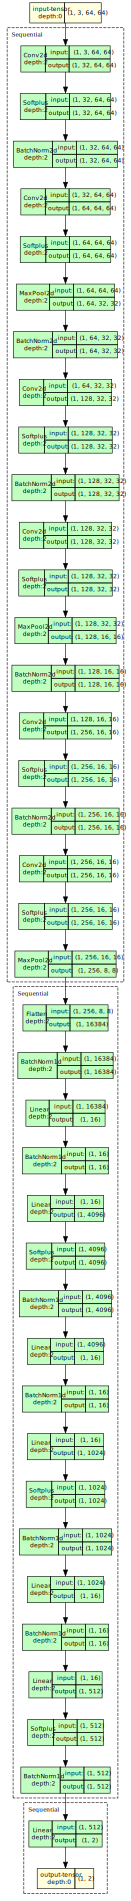

In [ ]:
import torchvision
from torchview import draw_graph
net2 = CelebA_CNN()

model_graph = draw_graph(net2, input_size=(1,3,64,64), expand_nested=True)
model_graph.visual_graph
